In [7]:
import boto3
import os
from io import BytesIO
from PIL import Image
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

Get a general understanding of the images

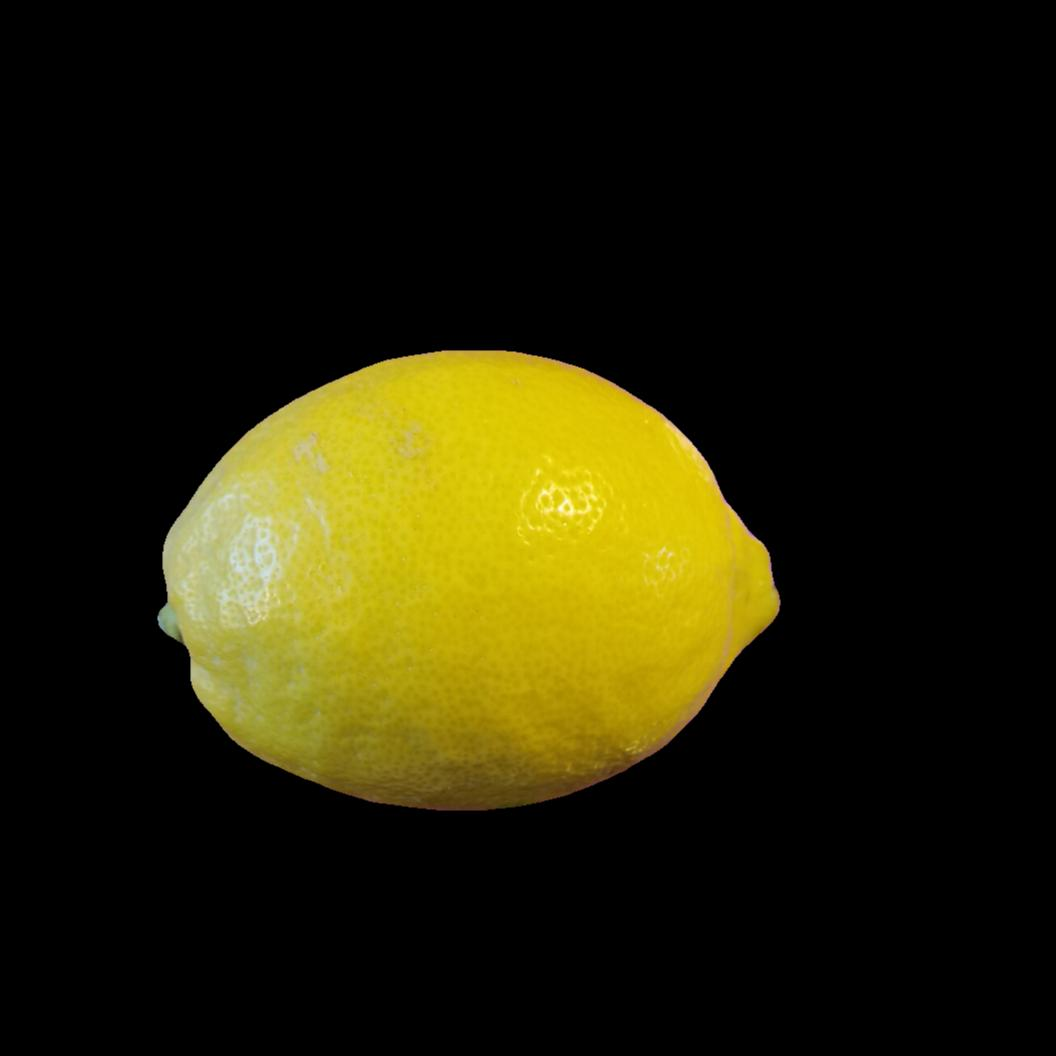

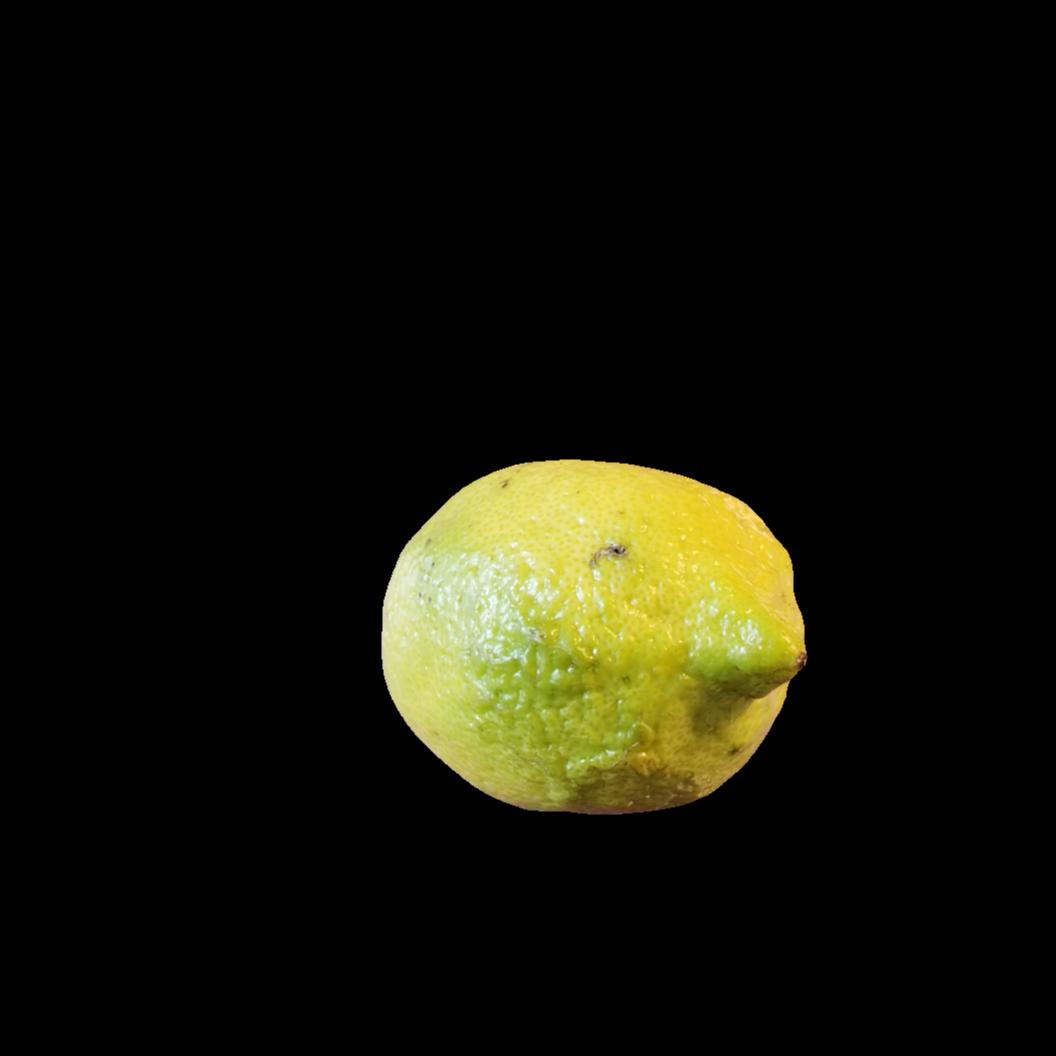

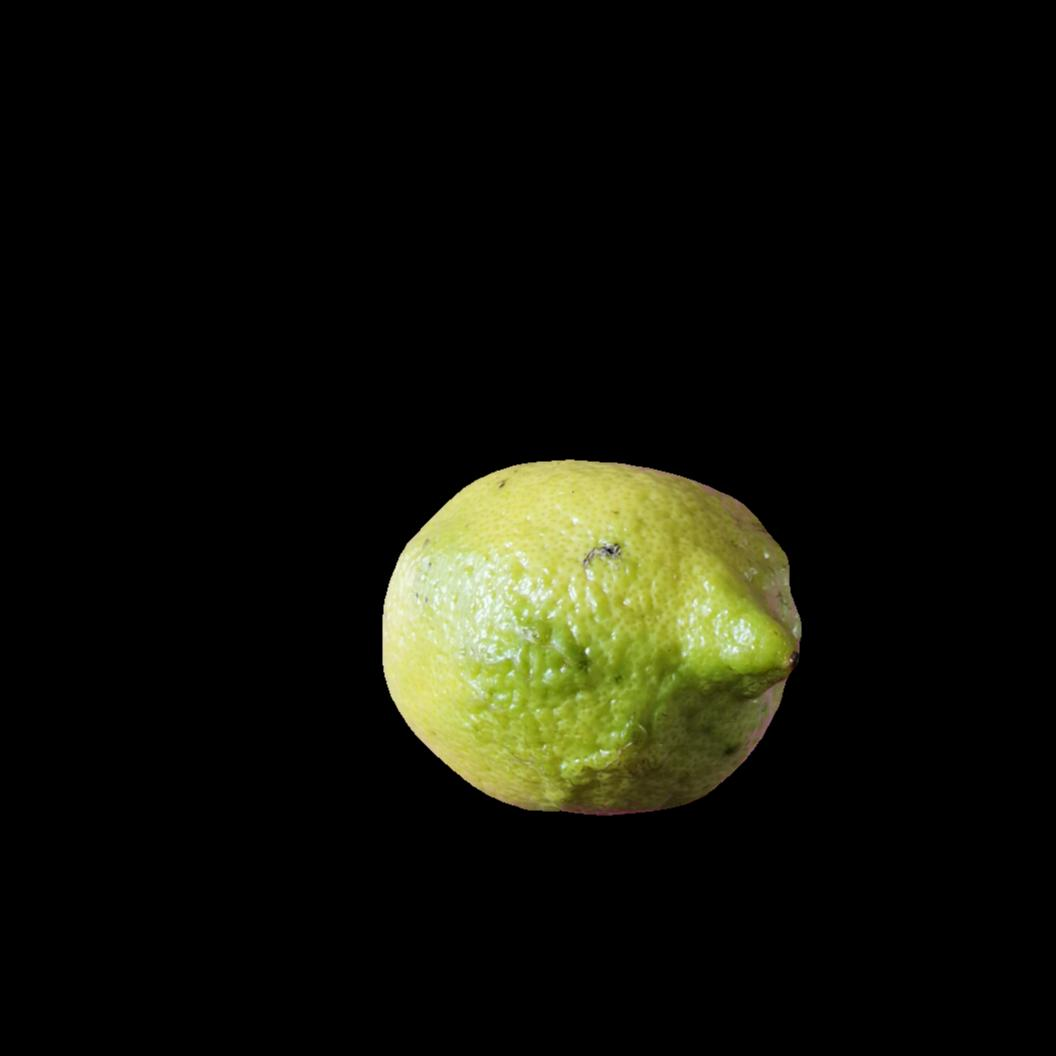

In [3]:
bucket_name = 'lemondataset'
prefix = 'lemon-dataset/lemon-dataset/images/'  # Folder inside the bucket
s3 = boto3.client('s3')
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

# Get the first 3 images in folder
image_keys = [obj['Key'] for obj in response.get('Contents', []) if obj['Key'].lower().endswith(('jpg', 'jpeg', 'png'))][:3]

for key in image_keys:
    obj = s3.get_object(Bucket=bucket_name, Key=key)
    img = Image.open(BytesIO(obj['Body'].read()))
    display(img)  # Displays the image in Jupyter Notebook

In [11]:
Step 2 understand class & image characteristic distribution

In [12]:

json_s3_key = "lemon-dataset/lemon-dataset/annotations/instances_default.json"

# Download the JSON file from S3
json_obj = s3.get_object(Bucket=bucket_name, Key=json_s3_key)
coco_data = json.load(json_obj["Body"])


print(f"Number of Images: {len(coco_data['images'])}")
print(f"Number of Annotations: {len(coco_data['annotations'])}")
print(f"Number of Categories: {len(coco_data['categories'])}")

df_images = pd.DataFrame(coco_data["images"])
df_annotations = pd.DataFrame(coco_data["annotations"])
df_categories = pd.DataFrame(coco_data["categories"])


COCO Dataset Loaded
Number of Images: 2690
Number of Annotations: 33753
Number of Categories: 9


/tmp/ipykernel_142/4127869467.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Count", y="Category", data=df_category_counts, palette="viridis")


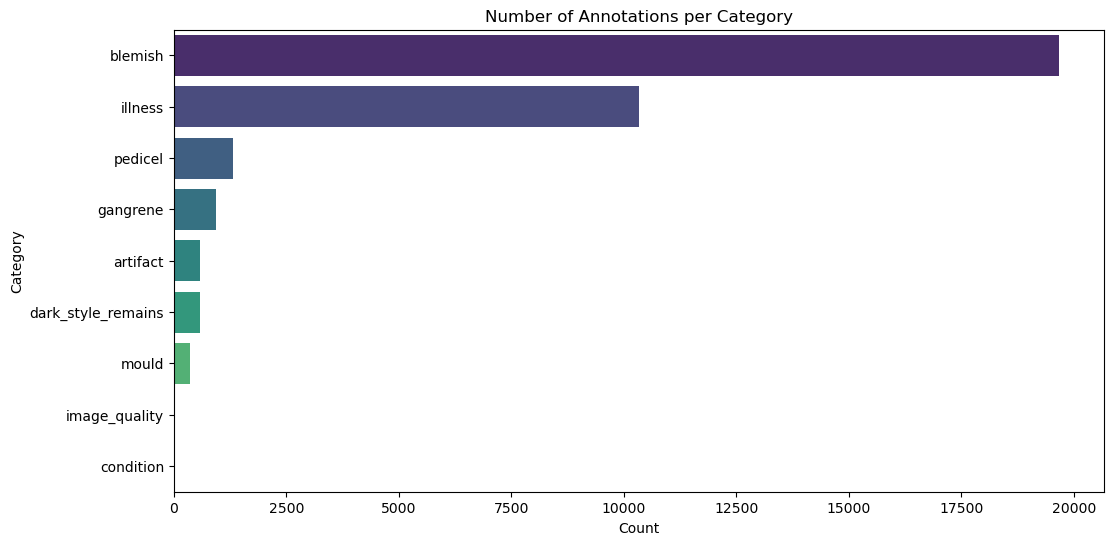

In [14]:
category_mapping = {cat["id"]: cat["name"] for cat in coco_data["categories"]}

category_counts = defaultdict(int)
for ann in coco_data["annotations"]:
    category_counts[category_mapping[ann["category_id"]]] += 1

# Convert to df to make use of seaborn
df_category_counts = pd.DataFrame(list(category_counts.items()), columns=["Category", "Count"])
df_category_counts = df_category_counts.sort_values(by="Count", ascending=False)


plt.figure(figsize=(12, 6))
sns.barplot(x="Count", y="Category", data=df_category_counts, palette="viridis")
plt.title("Number of Annotations per Category")
plt.xlabel("Count")
plt.ylabel("Category")
plt.show()

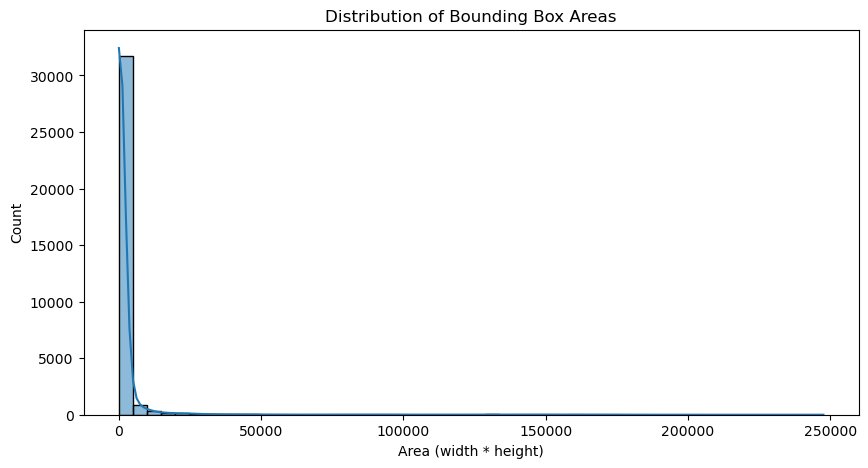

In [17]:
df_annotations["bbox_width"] = df_annotations["bbox"].apply(lambda x: x[2])
df_annotations["bbox_height"] = df_annotations["bbox"].apply(lambda x: x[3])
df_annotations["bbox_area"] = df_annotations["bbox_width"] * df_annotations["bbox_height"]




# Plot bounding box area distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_annotations["bbox_area"], bins=50, kde=True)
plt.title("Distribution of Bounding Box Areas")
plt.xlabel("Area (width * height)")
plt.show()

In [18]:
print("\nBounding Box Stats:\n", df_annotations[["bbox_width", "bbox_height", "bbox_area"]].describe())


Bounding Box Stats:
          bbox_width   bbox_height      bbox_area
count  33753.000000  33753.000000   33753.000000
mean      25.416574     25.142335    2528.362970
std       45.402822     46.251245   14337.656522
min        1.500000      1.500000       2.550000
25%        6.106307      5.904431      37.960000
50%       12.023193     11.400000     140.075290
75%       25.974075     24.559104     608.600018
max      582.370558    569.890664  247588.495891


In [16]:
# 7. Quick Check: Unique Image Dimensions
#############################
print("Unique image dimensions:", df_images[['width', 'height']].drop_duplicates().values)

Unique image dimensions: [[1056 1056]]


In [ ]:
# all images are the same size